## Import libraries

In [1]:
import cv2
import json
import math
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import re

from pathlib import Path
from PIL import Image

%matplotlib inline

cwd = Path.cwd()
cwd

PosixPath('/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract')

## Import Segmentation Images

In [3]:
COLOR_DICT = {
    'Blood': 'red',
    'Blood vessel': 'blue',
    'Arachnoid': 'green',
    'Tumour Core': 'yellow',
    'Cortical Surface': 'cyan',
    'Tumour Margins': 'magenta',
    'White Matter': 'white',
}

RGB_IMG_PATTERN = '.*\.JPG'
MASK_PATTERN = '.*\.json'

class SegmentedImage:

    def __init__(self, img_path, mask_path=None):
        self.img = self._import_image(img_path)
        self.mask = self._import_mask(mask_path)
    

    def _import_image(self, img_path):
        return np.asarray(Image.open(img_path))
    

    def _import_mask(self, mask_path):
        if mask_path == None:
            return None
        seg_dict = json.load(mask_path.open())
        return seg_dict['shapes']


# Image Plotting
def plot_image(image_obj, ax=None):

    if ax == None:
        fig, ax = plt.subplots()

    if hasattr(image_obj, 'img'):
        img = image_obj.img
        mask = image_obj.mask
        ax.imshow(img)
    else:
        img = image_obj
        mask = None
        ax.imshow(img, norm=colors.Normalize(), cmap='gray')
    ax.axis('off')

    if mask != None:
        for shape in mask:
            if shape['shape_type'] == 'linestrip':
                x, y = zip(*shape['points'])
                ax.plot(x, y, linewidth=2, color=COLOR_DICT[shape['label']], alpha=0.3)
            if shape['shape_type'] == 'polygon':
                x, y = zip(*shape['points'])
                ax.fill(x, y, color=COLOR_DICT[shape['label']], alpha=0.3)


def plot_images(image_objs):
    fig, axes = plt.subplots(math.ceil(len(image_objs)/3), 3)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(image_objs):
            ax.axis('off')
            continue
        plot_image(image_objs[i], ax)
    
    plt.legend(bbox_to_anchor=(1,0), loc="lower right", handles=[mpatches.Patch(color=COLOR_DICT[label], label=label) for label in COLOR_DICT.keys()])
    plt.tight_layout()
    plt.show()

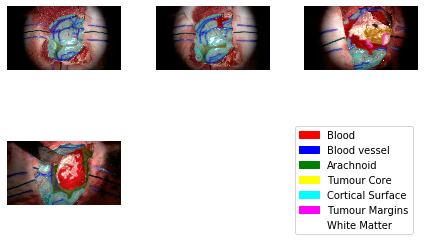

In [4]:
# seg_folder = Path(cwd, 'data', 'definitive-segmentation', 'HS001 - Trial with cappillary included')
seg_folder = Path(cwd, 'data', 'definitive-segmentation', 'HS001 - Trial with capillaries excluded')
seg_folders = [x for x in seg_folder.iterdir() if x.is_dir()]
seg_folders.sort()

seg_files = []
for fold in seg_folders:
    img_path = [x for x in fold.iterdir() if re.match(RGB_IMG_PATTERN, x.name)][0]
    mask_path = [x for x in fold.iterdir() if re.match(MASK_PATTERN, x.name)][0]
    seg_files.append(SegmentedImage(img_path, mask_path))

plot_images(seg_files)

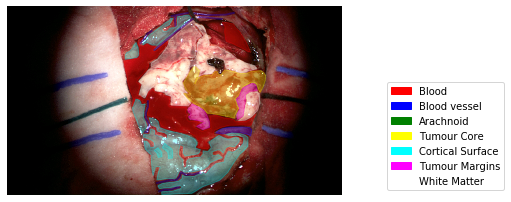

In [5]:
plot_image(seg_files[2])
plt.legend(bbox_to_anchor=(1.5,0), loc="lower right", handles=[mpatches.Patch(color=COLOR_DICT[label], label=label) for label in COLOR_DICT.keys()])

## Import Hyperspectral Images

In [6]:
HS_IMG_PATTERN = '.*\.png'
lambda_pattern = '\s\d{3}'

class HSImage:

    def __init__(self, run_id, img_paths):
        self.run_id = run_id
        self.imgs = self._import_images(img_paths)
    

    def _import_images(self, img_paths):
        img_paths.sort()
        img_lambdas = [re.findall(lambda_pattern, x.name)[0].strip() for x in img_paths]
        img_lambdas.sort()

        img_dict = dict()
        for i, img_path in enumerate(img_paths):
            img_dict[img_lambdas[i]] = np.asarray(Image.open(img_path))
        return img_dict

    
    def get_lambdas(self):
        return sorted(self.imgs.keys())

In [7]:
run_folder = Path(cwd, 'data', 'runs')
run_folders = [x for x in run_folder.iterdir() if x.is_dir()]
run_folders.sort()

run_files = []
for fold in run_folders:
    run_id = fold.name
    img_paths = [x for x in fold.iterdir() if re.match(HS_IMG_PATTERN, x.name)]
    run_files.append(HSImage(run_id, img_paths))

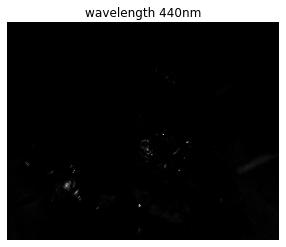

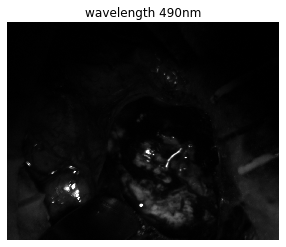

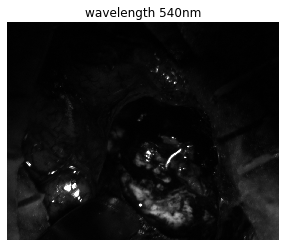

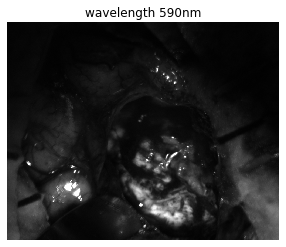

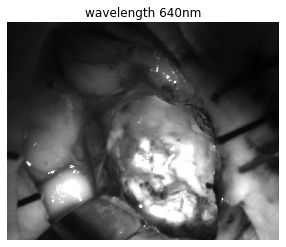

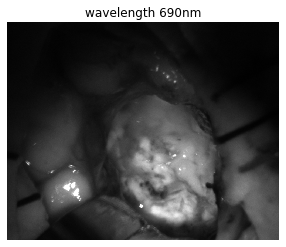

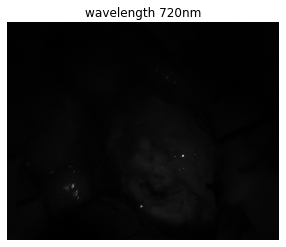

In [8]:
wavelengths = [0, 5, 10, 15, 20, 25, 28]
for l in wavelengths:
    idx = run_files[3].get_lambdas()[l]
    fig, ax = plt.subplots()
    ax.set_title(f'wavelength {idx}nm')
    plot_image(run_files[3].imgs[idx], ax)

In [9]:
ref_folder = Path(cwd, 'data', 'ref-runs')
ref_folders = [x for x in ref_folder.iterdir() if x.is_dir()]
ref_folders.sort()

ref_files = []
for fold in ref_folders:
    run_id = fold.name
    img_paths = [x for x in fold.iterdir() if re.match(HS_IMG_PATTERN, x.name)]
    ref_files.append(HSImage(run_id, img_paths))

white_reference = ref_files[0]
dark_reference = ref_files[1]

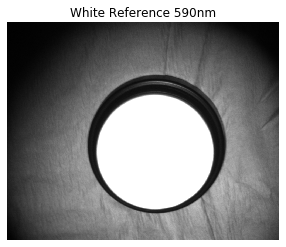

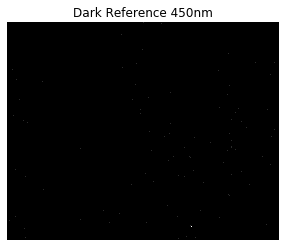

In [10]:
idx = white_reference.get_lambdas()[15]
fig, ax = plt.subplots()
ax.set_title(f'White Reference {idx}nm')
plot_image(white_reference.imgs[idx], ax)

idx = dark_reference.get_lambdas()[1]
fig, ax = plt.subplots()
ax.set_title(f'Dark Reference {idx}nm')
plot_image(dark_reference.imgs[idx], ax)

True

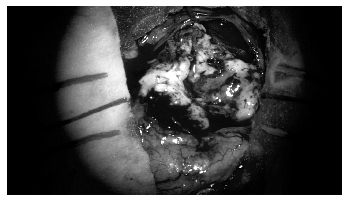

In [13]:
test_seg = seg_files[2]

fig, ax = plt.subplots()
ax.imshow(test_seg.img[:,:,1], norm=colors.Normalize(), cmap='gray')
ax.axis('off')

cv2.imwrite('test.png', test_seg.img[:,:,1])